# Промышленность — задача проекта

Оптимизация производственных расходов в металлургическом комбинате. Для уменьшения потребление электроэнергии на этапе обработки стали предстоит построить модель, которая предскажет ее температуру.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



## Оглавление
1. [Загрузка и просмотр данных](#1)
2. [Иследовательский анализ](#2)
3. [Подготовка данных для обучения](#3)
4. [Обучение моделей](#4)
   - [Обучение Lasso и отбор признаков](#4.1)
   - [Обучение RandomForestRegressor](#4.2)
   - [Обучение CatBoostRegressor](#4.3)
5. [Проверка модели на тестовых данных](#5)
6. [Вывод](#6)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

<a id='1'>
    
## 1. Загрузка и просмотр данных

In [12]:
df_arc = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_arc.csv', parse_dates=[1, 2])
df_bulk = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_bulk.csv')
df_bulk_time = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_bulk_time.csv', 
                           parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
df_gas = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_gas.csv')
df_temp = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_temp.csv', parse_dates=[1])
df_wire = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\\data_wire.csv')
df_wire_time = pd.read_csv(r'C:\Users\Admin\Desktop\финальный проект\final_steel\data_wire_time.csv',
                           parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [14]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [15]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [16]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [17]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [19]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [20]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [21]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [23]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [24]:
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [25]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [28]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [29]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Данных не мало, почти во всех есть пропуски, но при нашей задачи основной датафрейм это `df_temp`, где хранятся данные по замерам температуры. На первый взгляд это работа с времмеными рядами, но сделаем вывод, когда уточним все вопросы)

<a id='2'>
    
## 2. Иследовательский анализ

У нас стоит задача предсказания температуры стали, а задача для предприятия уменьшить электропотребление, значит в первую очередь посмотрим на данные в `df_arc`, где показана мощьность электродов. Сгенерируем еще 2 переменные, которая показывает время нагрева дугой иполную мощность, и посмотрим как распеределены эти данные.

In [30]:
df_arc['Время нагрева дугой'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds.astype(int)
df_arc['Полная мощность'] = np.sqrt(df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2)

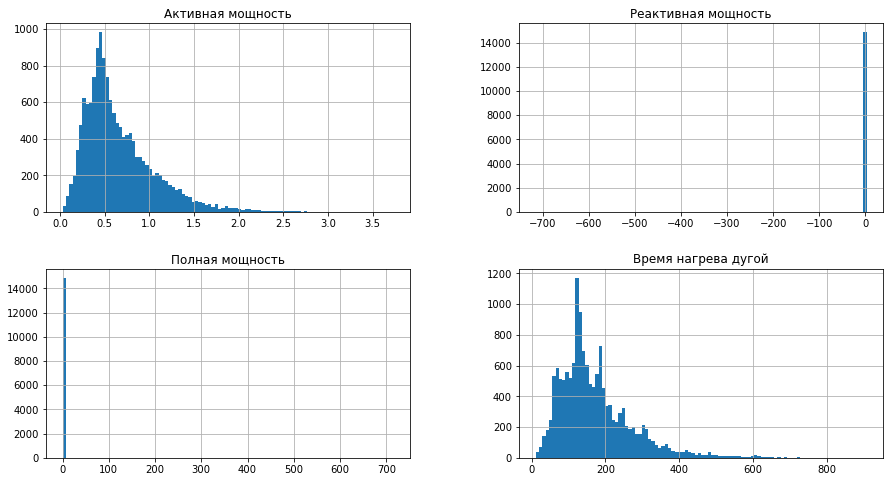

In [31]:
df_arc[['Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой']].hist(figsize=(15, 8), bins=100);

In [32]:
df_arc.loc[df_arc['Полная мощность'] > 2].sort_values(by='Полная мощность', ascending=False).head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Полная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109,715.505096
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388,907,4.592152
9226,2001,2019-07-19 20:19:15,2019-07-19 20:31:16,3.156276,2.504206,721,4.029036
12424,2701,2019-08-13 06:11:16,2019-08-13 06:25:02,3.150762,2.397032,826,3.958922
14200,3086,2019-08-27 03:41:09,2019-08-27 03:53:10,3.052813,2.216230,721,3.772445


И тут у нас явный выброс, реактивная мощность конечно допускается быть отрицательной, но не в таком диапазоне, это явно аномалия, которой тут не место.

Теперь посмотрим на `df_temp`, где у нас произведены замеры по температуре

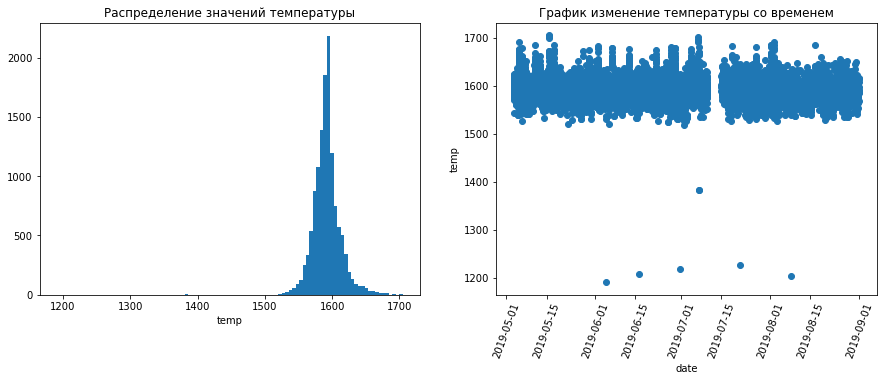

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Распределение значений температуры')
plt.xlabel('temp')
plt.hist(df_temp['Температура'], bins=100)

plt.subplot(1, 2, 2)
plt.title('График изменение температуры со временем')
plt.scatter(df_temp['Время замера'], df_temp['Температура'])
plt.xlabel('date')
plt.ylabel('temp')
plt.xticks(rotation=70)
plt.show()

In [34]:
print(f'Средняя температура стали: {df_temp["Температура"].mean()}')

Средняя температура стали: 1591.8409195755805


Из графика так же видны аномалии, посмотрим на эти значения...

In [35]:
df_temp.query('Температура < 1500')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


При средней температуры стали в 1500 градусов, эти значения выбиваются. Поэтому удалим их.

In [36]:
df_temp = df_temp.drop(df_temp.query('Температура < 1500').index)

In [37]:
df_temp.groupby('key', as_index=False)['Температура'].count().sort_values(by='Температура')

,key,Температура
2538,2561,0
3215,3241,1
2785,2809,1
2784,2808,1
2783,2807,1
...,...,...
1201,1214,15
2091,2108,15
41,44,16
43,46,16


Еще посмотрим какая была температура у нашей аномалии в данных об электродах, для этого отберем номер партии 2116

In [38]:
df_temp.query('key == 2116')

,key,Время замера,Температура
10462,2116,2019-07-24 00:32:59,1579.0
10463,2116,2019-07-24 00:44:34,1574.0
10464,2116,2019-07-24 00:50:58,1578.0
10465,2116,2019-07-24 00:53:31,1578.0


Здесь ничиго не обычного не наблюдается..

### Вывод
Значит так, что мы имеем:
   - 7 таблиц, которые несут различную информацию по времени, подачи материалов, измерения температуры и данные по электродам.
   - Наша задача построить модель которая предскажет температуру в ковше, для уменьшение электропотребления.
   
Следовательно есть вопрос, от чего зависит температура в ковше, судя по данным она от них не зависит?
Средняя температура 1591 градус, то есть она должна не сильно отклоняться от среднего?
Так же не понятно, как происходят замеры температуры, сколько всего дожно быть замеров у партии, т.к. у одной партии эти значения варьируются от 1 до 16?
Плюс в целевой переменной достаточно много пропусков, и от этих вопросов, будет зависить что с ними делать, удалять или восстанавливать.

### Примерный план
Выяснить, какую задачу мы решаем табличных данных или временных рядов.

Если временные ряды, то так как ряд стационарный, можно использовать семейства моделей АРИМА, либо другие регрессионные модели, такие как линейная регреессия и бустинги.

Если у нас задачи обычных табличных данных, то подойт все тоже самое, кроме моделей АРИМА
   

<a id='3'>
    
## 3. Подготовка данных для обучения

И так мы выяснили, изменение температуры у нас зависит от множество факторов, которые порой тяжело предсказать. Но у нас есть различная информация, которая также имеет влияние на температуру. Следовательно нужно все таблицы объединить в одну. Теперь как мы это будем делать. Нам известен целевой признак, который предстоит предсказывать, это последнее измерение температуры партии, то есть темперетура, которая получается на выходе партии. Какие таблицы у нас имееются:
   - data_arc.csv — данные об электродах;
   - data_bulk.csv — данные о подаче сыпучих материалов (объём);
   - data_bulk_time.csv — данные о подаче сыпучих материалов (время);
   - data_gas.csv — данные о продувке сплава газом;
   - data_temp.csv — результаты измерения температуры;
   - data_wire.csv — данные о проволочных материалах (объём);
   - data_wire_time.csv — данные о проволочных материалах (время)

Из всех таблиц нам не потребутся только 2 это `data_bulk_time.csv` и `data_wire_time.csv`, потому что данные о времени, когда были добавлены эти присадки, в модели точно не нужны. Данные по температуре и электродам нам придется агрегировать, если по температуре мы знаем какой признак от туда вытянуть, то с электродами не все так очевидно. С этой таблицой нужно поэксперементировать. Во первых, мной в иследовательском анализе были сгенерированы дополнительные фитчи, которые также будут учавствовать в обучение.

Для начала сформируем дополнительные фитчи они будут показывать долю активной мощности и отношение активной к реактивной мощности. Сгрупируем все значения по партиям и применим агрегирующую функцию суммы

In [39]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


In [40]:
df_arc['Доля активной мощности'] = df_arc['Активная мощность'] / df_arc['Полная мощность']
df_arc['Отношение активной к реактивной мощности'] = df_arc['Активная мощность'] / df_arc['Реактивная мощность']
df_arc_group = df_arc.pivot_table(index='key', aggfunc=['sum']).reset_index()
df_arc_group.columns = [x + '_' + y for x, y in df_arc_group.columns]
df_arc_group = df_arc_group.rename(columns={'key_': 'key'})

In [41]:
df_arc_group.head()

,key,sum_Активная мощность,sum_Время нагрева дугой,sum_Доля активной мощности,sum_Отношение активной к реактивной мощности,sum_Полная мощность,sum_Реактивная мощность
0,1,4.878147,1098,4.188779,7.694490,5.826395,3.183241
1,2,3.052598,811,3.360633,6.207336,3.649216,1.998112
2,3,2.525882,655,4.227104,7.915599,2.989534,1.599076
3,4,3.209250,741,3.366728,6.253946,3.814962,2.060298
4,5,3.347173,869,3.312418,5.921711,4.035758,2.252643


Далее перейдем к нашей основной таблице `data_temp.csv`. Сначала мы оттуда выделим дополнительную фитчу, это первое измерение температуры, а целевым признаком у нас будет последняя температура. Пропуски у нас будут только в целевом признаке, и нам они не нужна поэтому сразу удалим

In [42]:
df = df_temp.pivot_table(index='key', values='Температура', aggfunc=['first', lambda x: x.iloc[-1]], dropna=False).reset_index()
df.columns = ['key', 'Температура на входе', 'Температура на выходе']
df = df.dropna()

In [43]:
df.head(), df.shape

(   key  Температура на входе  Температура на выходе
 0    1                1571.0                 1613.0
 1    2                1581.0                 1602.0
 2    3                1596.0                 1599.0
 3    4                1601.0                 1625.0
 4    5                1576.0                 1602.0,
 (2477, 3))

И так нужную таблицу мы обработали, теперь к ней будем крепить остальные признаки

In [44]:
df = df.merge(df_bulk, on='key', how='left')
df.shape

(2477, 18)

In [45]:
df = df.merge(df_gas, on='key', how='left')
df.shape

(2477, 19)

In [46]:
df = df.merge(df_wire, on='key', how='left')
df.shape

(2477, 28)

In [47]:
df = df.merge(df_arc_group, on='key', how='left')

In [48]:
df.shape

(2477, 34)

Пропуски в таблице будем считать, что материал не подавался, поэтому заменим их нулями

In [49]:
df = df.fillna(0)
df = df.set_index('key')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Температура на входе                          2477 non-null   float64
 1   Температура на выходе                         2477 non-null   float64
 2   Bulk 1                                        2477 non-null   float64
 3   Bulk 2                                        2477 non-null   float64
 4   Bulk 3                                        2477 non-null   float64
 5   Bulk 4                                        2477 non-null   float64
 6   Bulk 5                                        2477 non-null   float64
 7   Bulk 6                                        2477 non-null   float64
 8   Bulk 7                                        2477 non-null   float64
 9   Bulk 8                                        2477 non-null   f

Признаков получилось не мало, но все они могут оказаться бесполезны, из них нужно отобрать только те, которые хорошо описывают нашу целевую переменную. Посмотрим какая зависимость между признаками и целевой переменной..

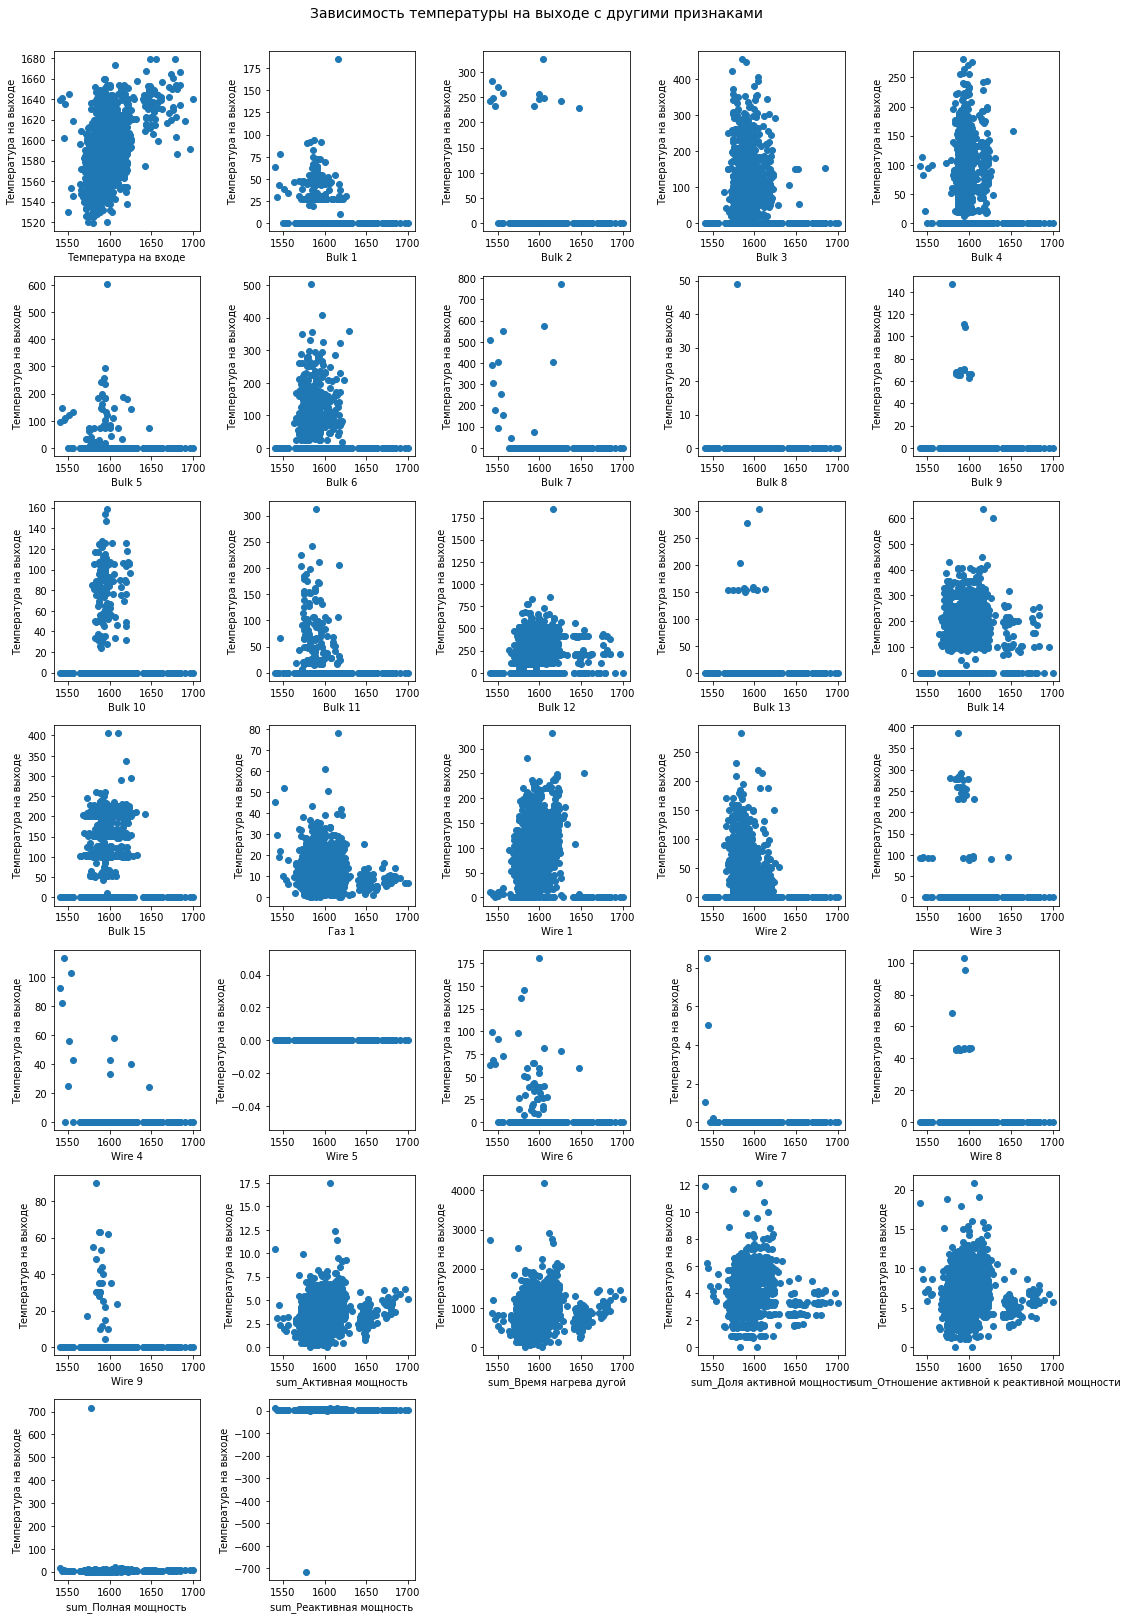

In [51]:
fig = plt.figure(figsize=(15, 25))
subplot = 1
plt.suptitle('Зависимость температуры на выходе с другими признаками', y=1.005, fontsize=14)
for col in df.drop('Температура на выходе', axis=1).columns:
    ax = fig.add_subplot(8, 5, subplot)
    plt.scatter('Температура на выходе', col, data=df)
    plt.xlabel(col)
    plt.ylabel('Температура на выходе')
    subplot += 1
    
plt.tight_layout()
plt.show()

На таких графиках как температура на входе, Bulk1, сумарное время нагрева дугой, сумарная активная мощность, просматривается линейная зависимость, но и дисперсия остатков там не малая, но в целом применить линейную модель можно.

Посмотрим как признаки коррелируют между собой...

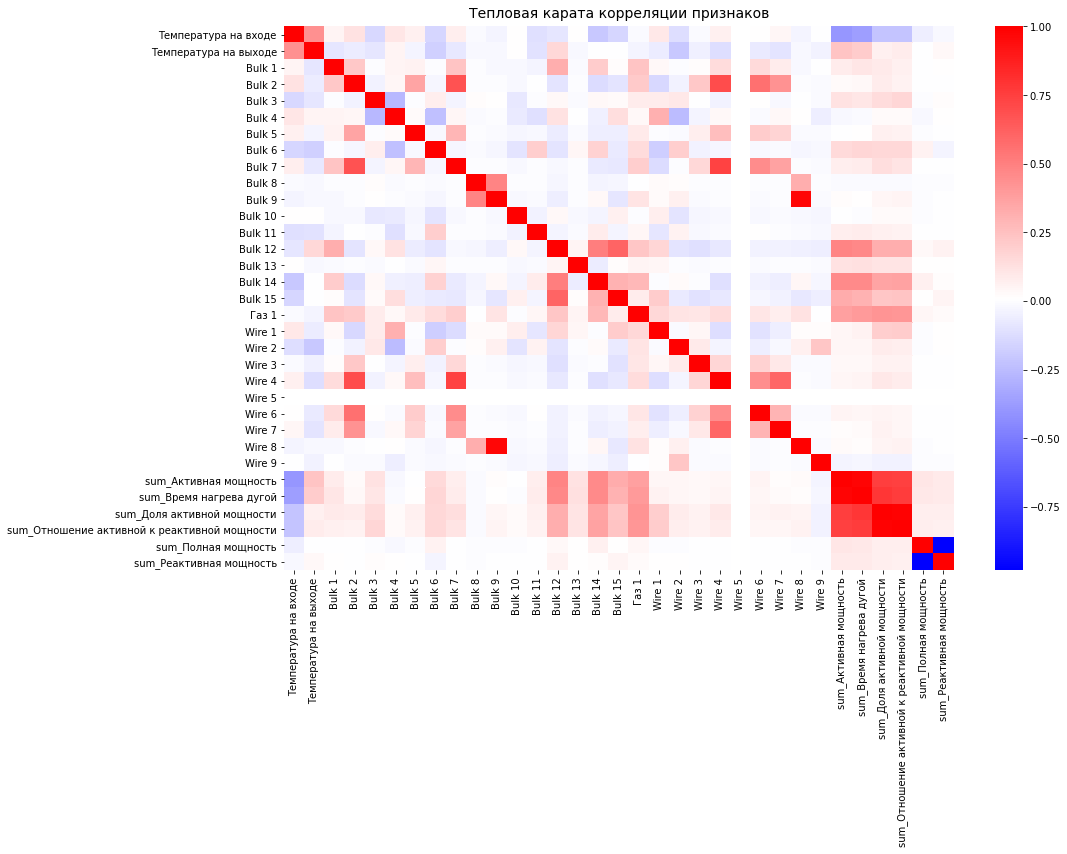

In [52]:
plt.figure(figsize=(15, 10))
plt.title('Тепловая карата корреляции признаков', fontsize=14, y=1.005)
sns.heatmap(df.corr(), cmap='bwr')
plt.show()

Тут есть прям явные признаки мультиколлиниарности, достаточно сильно между собой коррелируют суммарная активная мощность и сумарное время нагрева дугой и отрицательную коллиниарность имееют суммарная полная мощность и суммарная реактивная мощность. Из графика зависимости целевой переменной от всех принаков видно, что в сумарной активной и реактивной мощности наблюдается ярый выброс, которой в наши данные привносит путаницу, а если его убрать, то все значения станут близкие к 0, и зависимость с целевым признаком будет отсутствовать, поэтому эти 2 признака удалим. Что касается суммарной активной мощности и суммарное время нагрева дугой пока оставим, посмотрим на регрессионной модели какой признак окажется важным.

In [53]:
df = df.drop(['sum_Полная мощность', 'sum_Реактивная мощность'], axis=1)

In [54]:
df.head()

,Температура на входе,Температура на выходе,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_Активная мощность,sum_Время нагрева дугой,sum_Доля активной мощности,sum_Отношение активной к реактивной мощности
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.878147,1098.0,4.188779,7.694490
2,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.052598,811.0,3.360633,6.207336
3,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.525882,655.0,4.227104,7.915599
4,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.209250,741.0,3.366728,6.253946
5,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.347173,869.0,3.312418,5.921711


Таблица готова, теперь разделим данные на тестовую и тренировочную выборку

In [55]:
X = df.drop('Температура на выходе', axis=1)
y = df['Температура на выходе']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id='4'>
    
## 4. Обучение моделей

Начнем с обучения линейной регресси с регуляризаций l1. Этот метод хорош тем, что зануляет коэффициенты тех признаков, которое не привносят никакого вклада. Таким образом мы отберем нужные признаки, и остальные модели будем обучать на них.

In [57]:
# Функция для подбора гиперпараметров модели
def gridsearch(model, feature, params, scoring):
    gs = GridSearchCV(model, param_grid=params, scoring=scoring, cv=5)
    gs.fit(feature, y_train)
    scores = np.abs([gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)])
    print(f'scores: {scores}')
    print(f'mean_scores: {np.abs(gs.cv_results_["mean_test_score"][gs.best_index_])}')
    print(f'std_scores: +/-{np.abs(gs.cv_results_["std_test_score"][gs.best_index_])}')
    print(f'best_params: {gs.best_params_}')
    return gs.best_estimator_

In [58]:
# Функция для визуализации важности признаков
def plot_features_score(model, data, target, column_names):
    model.fit(data, target)
    (pd.DataFrame({'scores': model['lr'].coef_},
                   index=column_names)).sort_values(by='scores',ascending=False).plot(kind='barh', grid=True, figsize=(10,6));

In [59]:
# Функция для оценки качества моделей
def mae(y_true, y_pred):
    return np.sum(abs(y_true - y_pred)) / len(y_true)
scoring = make_scorer(mae, greater_is_better=False)

<a id='4.1'>

### 4.1 Обучение Lasso и отбор признаков

In [60]:
lr = Pipeline([('scaler', StandardScaler()), ('lr', Lasso())])

In [61]:
lr_params = {'lr__alpha': np.arange(0, 1, 0.01)}

In [62]:
%%time
gr_lr = gridsearch(lr, X_train, lr_params, scoring)

scores: [7.57128556 7.37095597 6.70166408 7.34074786 7.87323428]
mean_scores: 7.371577552082274
std_scores: +/-0.3850396537675523
best_params: {'lr__alpha': 0.04}
Wall time: 7.23 s


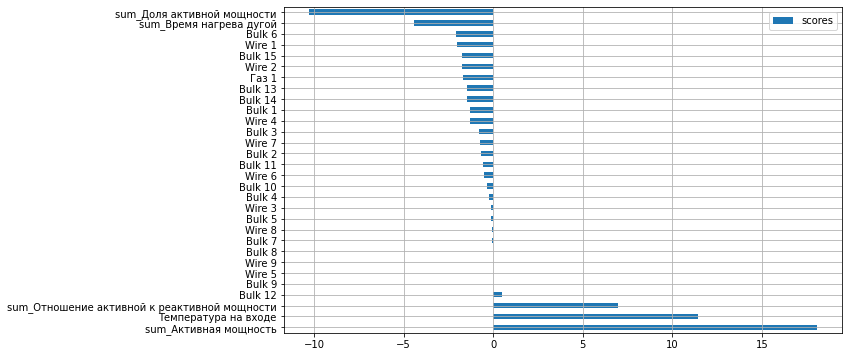

In [63]:
plot_features_score(gr_lr, X_train, y_train, X_train.columns)

Как мы видим некоторые признаки обнулены, то есть они не превносят никакого вклада. Отберем нужные признаки, для этого зададим порог 0.3. Выбран исходя из соображений, что не слишком много признаков отсеиваются и превносить вклад будет каждый признак

In [64]:
coef = pd.DataFrame({'columns': X_train.columns,
                     'coef':gr_lr['lr'].coef_})
mask_bool = np.abs(coef['coef']) > 0.3
mask = X_train.columns[mask_bool]
best_feature = X_train[mask]

In [65]:
%%time
gr_lr_best = gridsearch(lr, best_feature, lr_params, scoring)

scores: [7.37134267 7.3534601  6.68972065 7.32445737 7.89294272]
mean_scores: 7.326384704214815
std_scores: +/-0.3818604751587473
best_params: {'lr__alpha': 0.03}
Wall time: 6.07 s


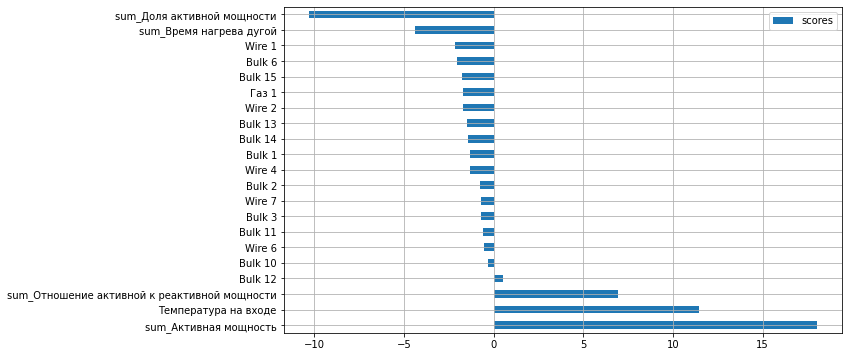

In [66]:
plot_features_score(gr_lr, best_feature, y_train, best_feature.columns)

Тепьрь как мы можем заметить оценка МАЕ стала немного лучше и все признаки превносят вклад, поэтому будем работать теперь с этими признаками

<a id='4.2'>

### 4.2 Обучение RandomForestRegressor

Теперь оценим как отработает модель случайного леса на этих признаках

In [67]:
rfr_params = {'max_depth': [10, 11 ,12],
              'max_features': [13, 15, 17],
              'random_state': [42]}

In [68]:
%%time
gr_rfr = gridsearch(RandomForestRegressor(), best_feature, rfr_params, scoring)

scores: [6.35362615 6.41453125 6.2989261  6.61436126 6.35323537]
mean_scores: 6.406936027717192
std_scores: +/-0.10997705156587305
best_params: {'max_depth': 11, 'max_features': 15, 'random_state': 42}
Wall time: 37.4 s


Тут мы результат улучшили что может не радовать)

<a id='4.3'>

### 4.3 Обучение CatBoostRegressor

In [69]:
cat_params = {'learning_rate': [0.05, 0.06],
              'loss_function': ['MAE'],
              'depth': [5, 6],
              'verbose': [0]}

In [70]:
%%time
gr_cat = gridsearch(CatBoostRegressor(), best_feature, cat_params, scoring)

scores: [6.04889344 6.22329772 5.6217222  6.04238543 6.31422762]
mean_scores: 6.050105281443505
std_scores: +/-0.23804594550113362
best_params: {'depth': 5, 'learning_rate': 0.06, 'loss_function': 'MAE', 'verbose': 0}
Wall time: 1min 28s


Тут у нас получился самый лучший результат, теперь проверим нашу лучшую модель на тестовых данных


<a id='5'>

## 5. Проверка модели на тестовых данных

Но сначала сделаем преобразования и отберем, те признаки которые учавствовали у нас в обучении

In [71]:
feature = X_test.columns[mask_bool]
feature_test = X_test[feature]

In [72]:
print('MAE on the test sample: {:.3}'.format(mean_absolute_error(y_test, gr_cat.predict(feature_test))))

MAE on the test sample: 5.69


###### И так наша лучшая модель дала оценку МАЕ 5.69 на тестовых данных

<a id='6'>

## 6. Вывод

И так, проведя иследовательский анализ и обучение моделей нам стало понятно, что для предсказания температуры на выходе нам все признаки не нужны, помимо этого есть признаки, которые мы сгенерировали и они внесли очень хороший вклад в описания нашей целевой переменной. Результат оказался достаточно хорошим для предсказания температуры на выходе. Не малый вклад внесла переменная `Температура на входе` этому параметру стоит уделить внимание и она должна быть около 1600 градусов иначе все предсказания поплывут, да и этот параметр важен в дальнейшем нагреве. Если он будет слишком низким придется увеличить время нагрева дугой, от этого затраты мощности будут больше.

<a id='7'>

# 7. Финальный отчет

   1. Загрузка данных.

Загрузили все данные, кратко помотрели на сами данные их статистические показатели, определили пропуски.

   2. Исследовательтский анализ.

Посмотрели на зависимость температуры от времени в таблице `df_temp`, определили выбросы и удалили их. Сгененерировали дополнительные признаки в таблице `df_arc`, время нагрева дугой и полная мощнсть. Посмотрели на их распределения, также определили выброс. Задали интересующие вопросы

   3. Подготовка данных к обучению.

Так как мы не знаем какой признак может себя проявить в обучении, то в таблице `df_arc` сгенерировали еще 2 дополнительные фитчи, отношение активной мощности к реактивной и доля активной мощности, сгрупировали по ключу партии с суммированием по всем признакам. Слегка преобразуем таблицу `df_temp`, данные сгруппируем по ключу партии, вывели целевой признак (последнее измерение температуры) и дополнительный признак для обучения (первое измерение температуры). Произвели слияение всех таблиц в общий датафрейм. Посмотрели как зависит целевая переменная от каждого признака и как коррелируют признаки между собой. Определил 2 бесполезные фитчи (сумма полной мощности и сумма реактивной мощности) удалили их. Разделили данные на тренировачную и тестовую выборки.

   4. Обучение модели

Так как признаков поулчилось не мало, то первую модель для обучения сделал линейную регрессию с коэффициентом регуляризации L1 (LASSO) произвели расчет МАЕ на кроссвалидации он составил 7.37, так же с помощью нее отобрали нужные признаки для обучения и обучили еще две модели RandomForestRegressor и CatBoostregressor. Получили результаты МАЕ 6.40 и 6.05 соотвественно. Лучший результат показал CatBoostRegressor, ее я и выбрали для дальнейшего продвижения.

   5. Проверка модели на тестовых данных.

В этом блоке я провел испытания лучшей модели на тестовых данных и получил оценку МАЕ 5.69. 